In [1]:
import os
if 'DISPLAY' in os.environ:
    del os.environ['DISPLAY']
import torch
import dill
import os.path as op
import numpy as np
import hnn_core
from hnn_core import simulate_dipole, Network, read_params, JoblibBackend
import matplotlib as mpl
import matplotlib.pyplot as plt
import sbi.utils as utils
from sbi.inference.base import infer
import multiprocessing
import datetime
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from scipy import interpolate
import glob
import pandas as pd

import sys
sys.path.append('../')
import spike_train_functions
import hnn_simnets_functions
import numba
import sbi_functions
from sbi_functions import run_simulator
from joblib import Parallel, delayed
import umap
import umap.plot
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0")


/home/ntolley/anaconda3/lib/python3.7/site-packages/elephant/pandas_bridge.py:22: DeprecationWarning: pandas_bridge module will be removed in Elephant v0.8.x
  DeprecationWarning)
/home/ntolley/anaconda3/lib/python3.7/site-packages/holoviews/operation/datashader.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Callable


In [2]:
save_name = 'ERP_Yes_t1000000_02262021_124114'
data_path = '/home/ntolley/Jones_Lab/sbi_hnn/data/ERP/prerun_simulations/' + save_name + '/'

prior_dict_file = open(data_path + 'prior_dict_' + save_name + '.pkl', 'rb')
prior_dict = dill.load(prior_dict_file)
prior_dict_file.close()

prior_file = open(data_path + 'prior_' + save_name + '.pkl', 'rb')
prior = dill.load(prior_file)   
prior_file.close()

params_fname_file = open(data_path + 'params_fname_' + save_name + '.pkl', 'rb')
params_fname = dill.load(params_fname_file)
params_fname_file.close()

dpl_files = sorted(glob.glob(data_path + 'data/dpl*'))
theta_files = sorted(glob.glob(data_path + 'data/theta*'))
spike_gids_files = sorted(glob.glob(data_path + 'data/spike_gids*'))
spike_times_files = sorted(glob.glob(data_path + 'data/spike_times*'))
spike_types_files = sorted(glob.glob(data_path + 'data/spike_types*'))

In [3]:
dpl_preprocessed_file = open(data_path + 'dpl_ERP_preprocessed_100x_downsample.pkl', 'rb')
dpl_preprocessed = dill.load(dpl_preprocessed_file)
dpl_preprocessed_file.close()
dpl, theta, sim_times = dpl_preprocessed['dpl'], dpl_preprocessed['theta'], dpl_preprocessed['sim_times']
downsample = dpl_preprocessed['downsample']

ERPYes_dpl = np.loadtxt('../../data/ERP/ERPYes_dpl.txt', delimiter=',')[::downsample]
ERPNo_dpl = np.loadtxt('../../data/ERP/ERPNo_dpl.txt', delimiter=',')[::downsample]


# with open(spike_gids_files[file_idx], 'rb') as f:
#     spike_gids = dill.load(f)
# unique_gids = np.unique([gid for l in spike_gids for gid in l[0]])
# num_sims = len(spike_gids)

# with open(spike_times_files[file_idx], 'rb') as f:
#     spike_times = dill.load(f)

# spike_times_list = []
# for gid in unique_gids:
#     unit_trains = []
#     for sim_idx in range(num_sims):
#         gid_mask = np.in1d(spike_gids[sim_idx][0], gid)
#         unit_trains.append(np.array(spike_times[sim_idx][0])[gid_mask])
#     spike_times_list.append(unit_trains)



In [4]:
embedding_net = sbi_functions.model_ann(input_size=dpl.shape[1], output_size=10, layer_size=[200,50])

neural_posterior = utils.posterior_nn(model='maf', embedding_net=embedding_net)
inference = SNPE(prior=prior)
inference = inference.append_simulations(torch.as_tensor(theta).float(), torch.as_tensor(dpl).float())
density_estimator = inference.train(show_train_summary=True)
posterior = inference.build_posterior(density_estimator)

/home/ntolley/anaconda3/lib/python3.7/site-packages/nflows/transforms/standard.py:76: DeprecationWarning: Use PointwiseAffineTransform
  warnings.warn("Use PointwiseAffineTransform", DeprecationWarning)
Neural network successfully converged after 151 epochs.

        -------------------------
        ||||| ROUND 1 STATS |||||:
        -------------------------
        Epochs trained: 151
        Best validation performance: 67.0055
        -------------------------
        


In [5]:
# # ___Save posterior___
# posterior_files = {
#     'posterior': posterior,
#     'sim_times': sim_times,
#     'dpl_preprocessed': dpl_preprocessed
#     }

# save_file = open(data_path + 'posterior_files_ANN_embedding.pkl', 'wb')
# dill.dump(posterior_files, save_file)
# save_file.close()

In [4]:
# ___Load posterior___
posterior_file = open(data_path + 'posterior_files_ANN_embedding.pkl', 'rb')
posterior = dill.load(posterior_file)
posterior_file.close()
locals().update(posterior)

In [5]:
num_samples = 8
theta_samples_No = posterior.sample((num_samples,), x=ERPNo_dpl[::100])
theta_samples_Yes = posterior.sample((num_samples,), x=ERPYes_dpl[::100])

In [6]:
res_No = Parallel(n_jobs=8)(delayed(run_simulator)(theta_samples_No[sim_idx,:], params_fname, prior_dict, sim_idx) for sim_idx in range(num_samples))
res_Yes = Parallel(n_jobs=8)(delayed(run_simulator)(theta_samples_Yes[sim_idx,:], params_fname, prior_dict, sim_idx) for sim_idx in range(num_samples))


In [9]:
spike_times = [res_No[sim_idx][1][0] for sim_idx in range(len(res_No))]
spike_gids = [res_No[sim_idx][2][0] for sim_idx in range(len(res_No))]
spike_types = [res_No[sim_idx][3][0] for sim_idx in range(len(res_No))]
spikes = hnn_simnets_functions.tmpSpikes(spike_times, spike_gids, spike_types)
spikes_df_No = hnn_simnets_functions.make_spikes_df(spikes, num_trials=len(res_No))

spike_times = [res_Yes[sim_idx][1][0] for sim_idx in range(len(res_Yes))]
spike_gids = [res_Yes[sim_idx][2][0] for sim_idx in range(len(res_Yes))]
spike_types = [res_Yes[sim_idx][3][0] for sim_idx in range(len(res_Yes))]
spikes = hnn_simnets_functions.tmpSpikes(spike_times, spike_gids, spike_types)
spikes_df_Yes = hnn_simnets_functions.make_spikes_df(spikes, num_trials=len(res_Yes))

spikes_df_Yes['detected'] = np.repeat('Yes', len(spikes_df_Yes))
spikes_df_No['detected'] = np.repeat('No', len(spikes_df_No))
spikes_df_No['gid'] = spikes_df_No['gid'] + np.max(spikes_df_Yes['gid'].values)

spikes_df_all = pd.concat([spikes_df_Yes, spikes_df_No])

#Add colormap for type
type_color = {cell_type:type_idx for type_idx, cell_type in enumerate(np.unique(spikes_df_all['type'].values))}
spikes_df_all['color'] = [type_color[cell_type] for cell_type in spikes_df_all['type'].values]

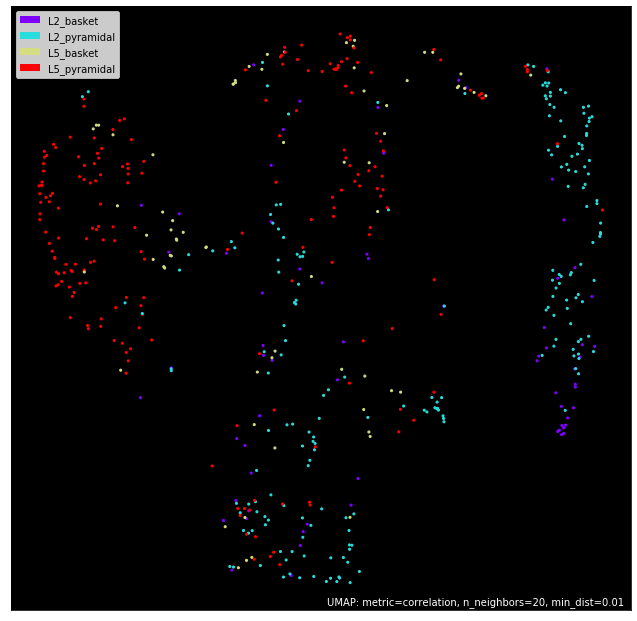

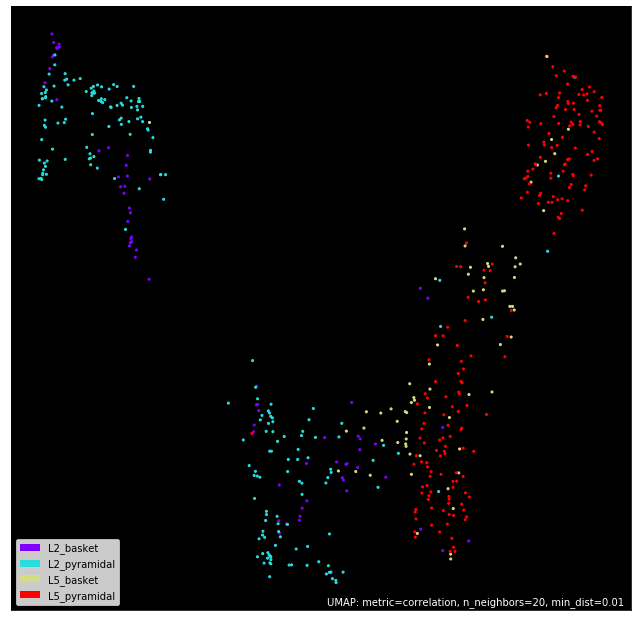

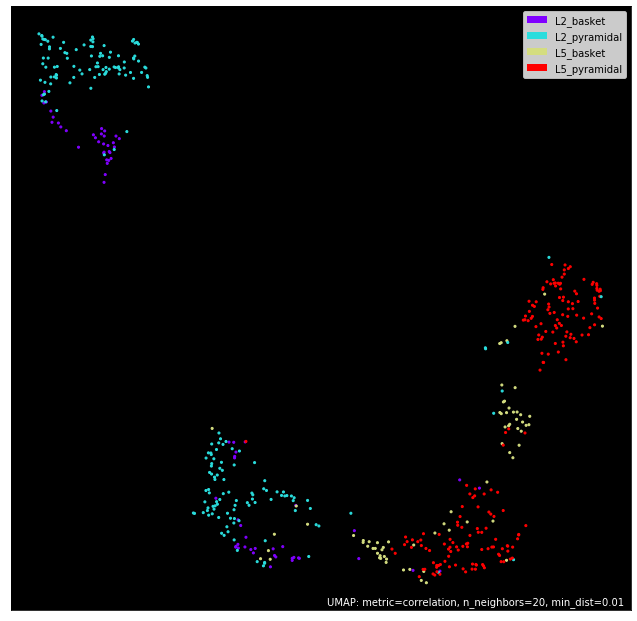

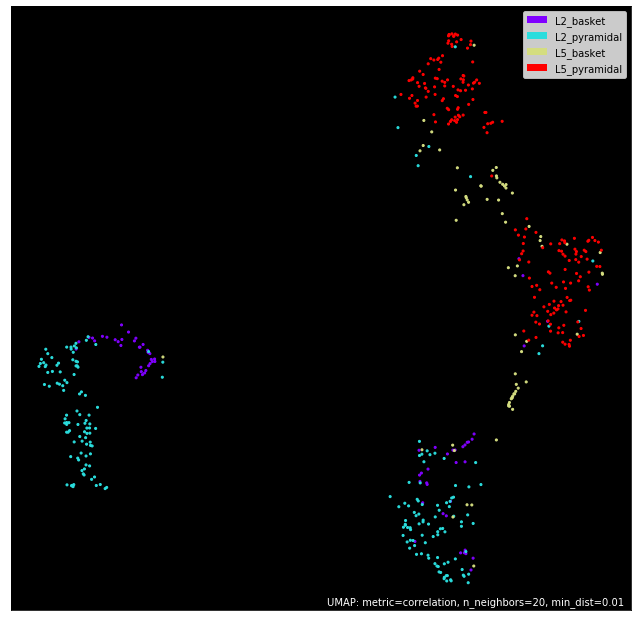

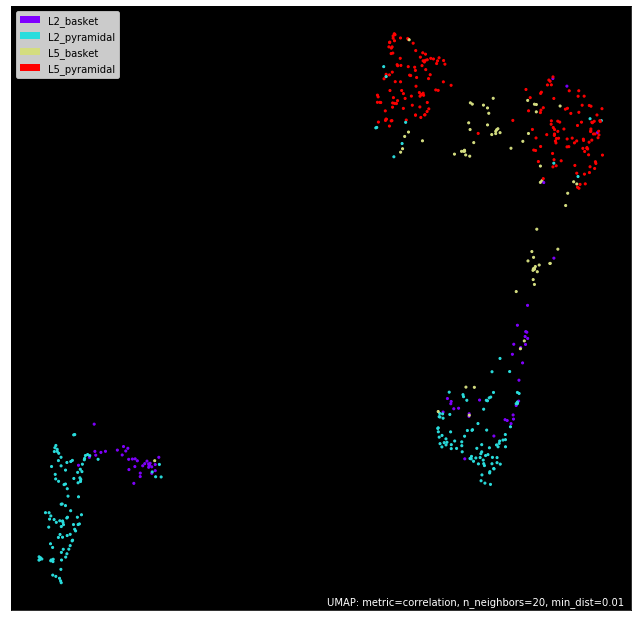

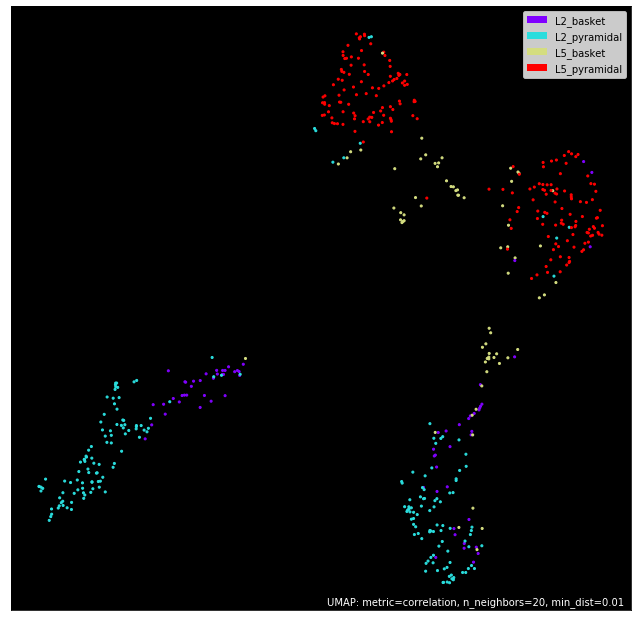

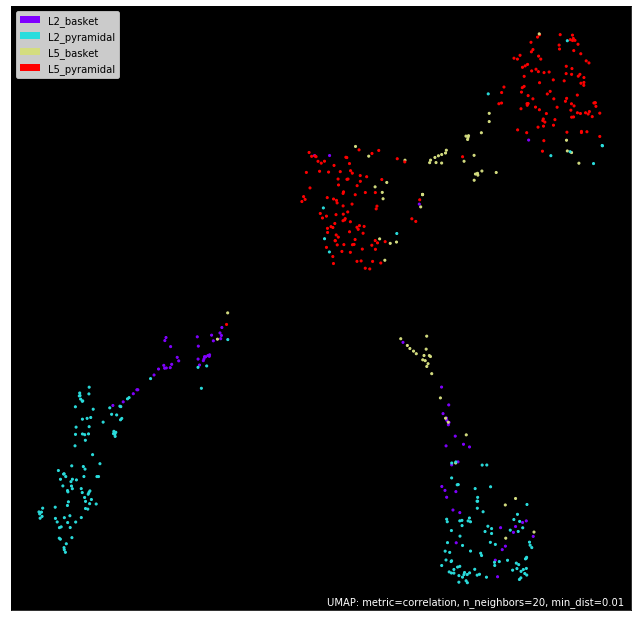

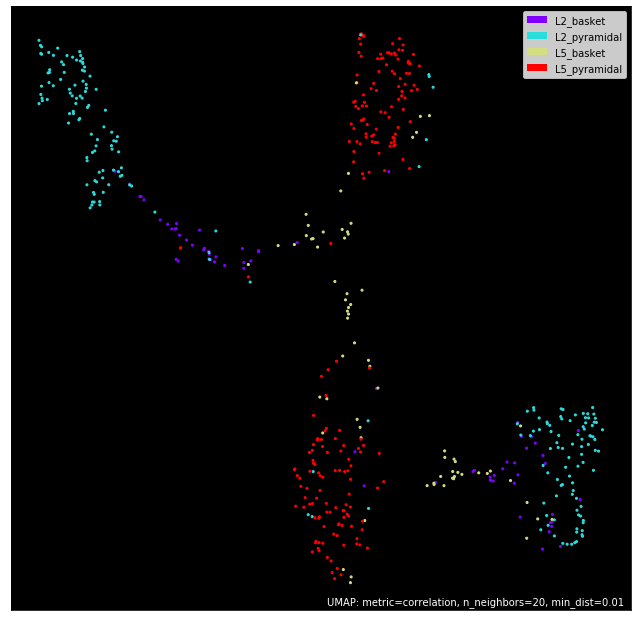

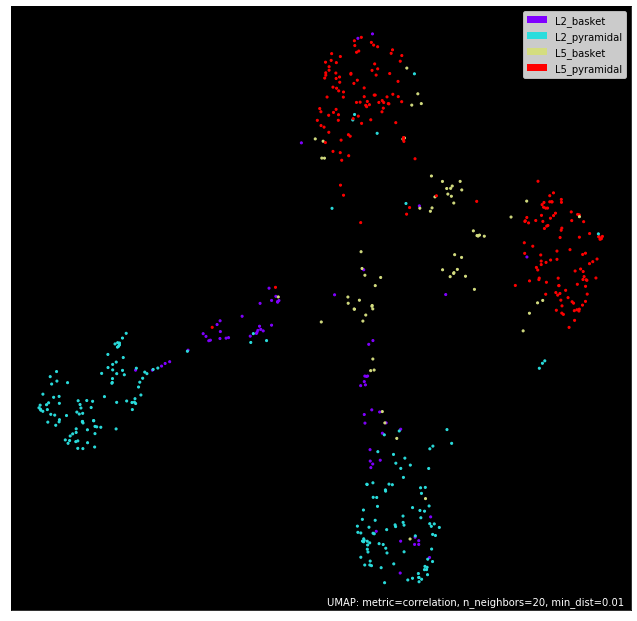

In [10]:
# spikes_df = spikes_df_all.groupby('gid').agg(lambda x: tuple(x)).applymap(list).reset_index()
# spikes_df['type'] = spikes_df['type'].map(lambda x: x[0])
# spikes_df['detected'] = spikes_df['detected'].map(lambda x: x[0])

# #Format timestamps columns into list of size num_trials, empty lists inserted on trials where no spikes fired
# grouped_ts = []
# trial_sim = []
# for gid in np.unique(spikes_df['gid'].values):
#     gid_ts = []
#     gid_trial_idx = 0 
#     for trial_idx in range(num_samples):
#         if trial_idx in spikes_df['trial'][spikes_df['gid'] == gid].values[0]:
#             gid_ts.append(np.array(spikes_df['timestamps'][spikes_df['gid'] == gid].values[0][gid_trial_idx]))
#             gid_trial_idx = gid_trial_idx + 1
#         else:
#             gid_ts.append(np.array([]))
#     grouped_ts.append(np.array(gid_ts))
#     trial_sim.append(spike_train_functions.vpTrialSimilarityMatrix(gid_ts,0.1).reshape((1,-1)).squeeze())
# spikes_df['grouped_ts'] = grouped_ts
# spikes_df['trial_sim'] = trial_sim
n_neighbors=20
min_dist=0.01
n_components=2
for q in np.linspace(0,1,9):
    spikes_df = spike_train_functions.grouped_ts_spikes_df(spikes_df_all, num_samples,q=q)
    mapper = umap.UMAP(metric='correlation',n_neighbors=n_neighbors, min_dist=min_dist, n_components=n_components).fit(np.stack(spikes_df['trial_sim'].values))
    umap.plot.points(mapper,labels = spikes_df['type'].values, theme='fire')
    # umap.plot.points(mapper,labels = spikes_df['detected'].values, theme='fire')

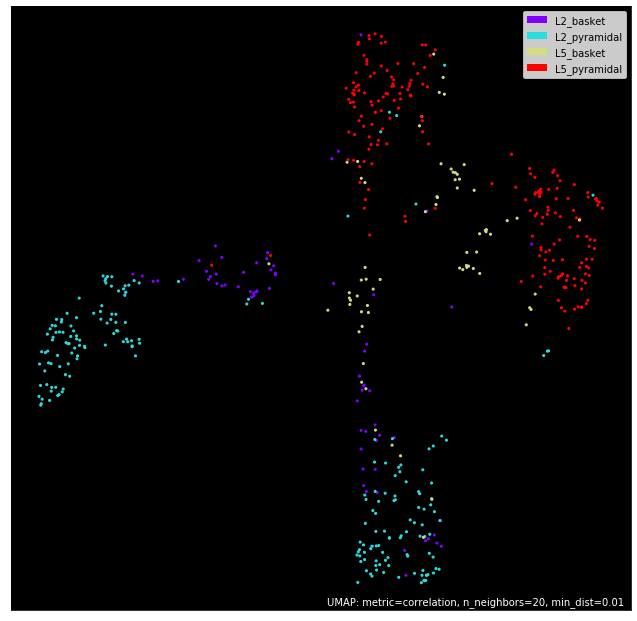

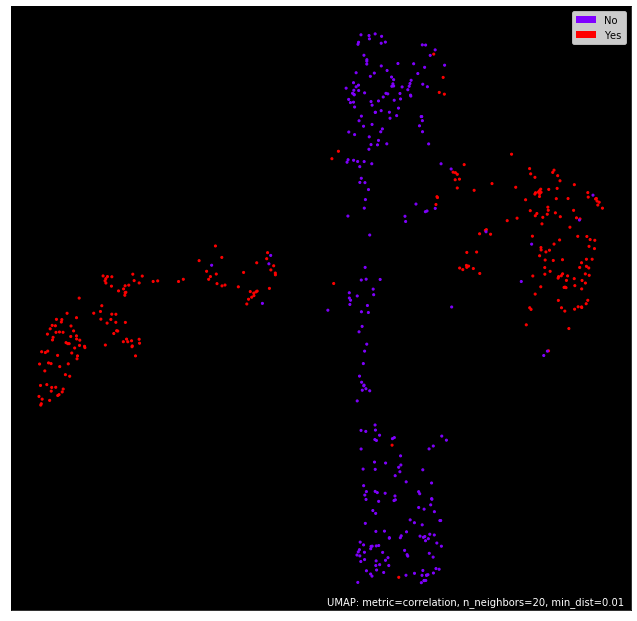

In [12]:
n_neighbors=20
min_dist=0.01
n_components=2
mapper = umap.UMAP(metric='correlation',n_neighbors=n_neighbors, min_dist=min_dist, n_components=n_components).fit(np.stack(spikes_df['trial_sim'].values))
umap.plot.points(mapper,labels = spikes_df['type'].values, theme='fire')
umap.plot.points(mapper,labels = spikes_df['detected'].values, theme='fire')

/home/ntolley/anaconda3/lib/python3.7/site-packages/umap/plot.py:850: UserWarning: Hammer edge bundling is expensive for large graphs!
This may take a long time to compute!
  "Hammer edge bundling is expensive for large graphs!\n"


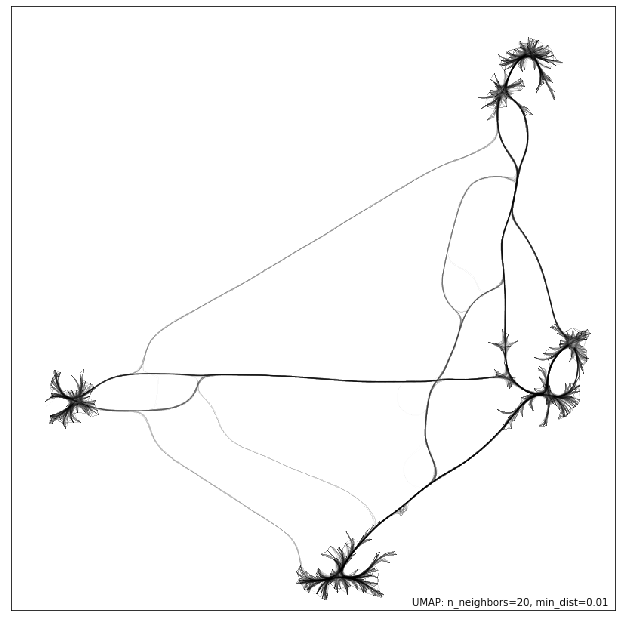

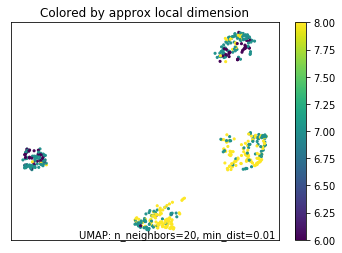

In [46]:
umap.plot.connectivity(mapper, edge_bundling='hammer')
umap.plot.diagnostic(mapper, diagnostic_type='local_dim')

(0, 175)

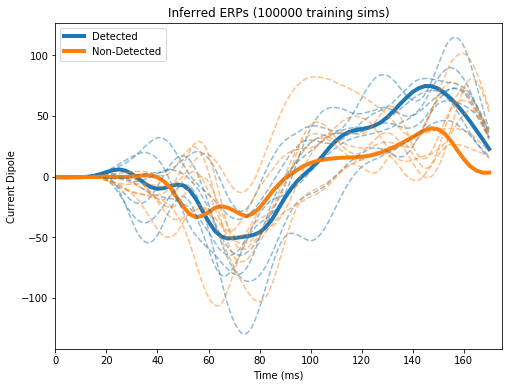

In [21]:
plt.figure(figsize=(8,6))
plt.plot(sim_times, ERPYes_dpl[::100], 'C0', LineWidth=4)
plt.plot(sim_times, ERPNo_dpl[::100], 'C1',LineWidth=4)
plt.legend(['Detected', 'Non-Detected'])
x_times = np.linspace(0,170,len(res_Yes[0][0]))
# for sim_idx in range(len(res_Yes)):
#     plt.plot(x_times, res_Yes[sim_idx][0], 'C0', LineStyle='--', alpha=0.5)
# for sim_idx in range(len(res_No)):
#     plt.plot(x_times, res_No[sim_idx][0], 'C1', LineStyle='--', alpha=0.5)


# plt.plot(x_times, res_Yes[0][0], 'C0', LineStyle='--', alpha=0.5)
# plt.plot(x_times, res_No[0][0], 'C1', LineStyle='--', alpha=0.5)
# plt.legend(['Detected', 'Non-Detected'])

plt.plot(x_times, np.vstack(res_Yes[sim_idx][0] for sim_idx in range(len(res_Yes))).transpose(), 'C0', LineStyle='--', alpha=0.5)
plt.plot(x_times, np.vstack(res_No[sim_idx][0] for sim_idx in range(len(res_No))).transpose(), 'C1', LineStyle='--', alpha=0.5)

plt.title('Inferred ERPs (100000 training sims)')
plt.ylabel('Current Dipole')
plt.xlabel('Time (ms)')
plt.xlim([0,175])
# plt.ylim([-55,205])